# 39) Stiff Equations

## Last time

* Ordinary differential equations (ODE)
* Stability of ODEs
* Explicit methods for solving ODE
* Linear Stability Analysis
* Numerical stability of ODEs

## Today

1. The $\theta$ methods
2. $A$-stability
3. $L$-stability
4. Stiff equations
5. PDE examples

In [3]:
using LinearAlgebra
using Plots
default(linewidth=4, legendfontsize=12)
using LaTeXStrings

struct RKTable
    A::Matrix
    b::Vector
    c::Vector
    function RKTable(A, b)
        s = length(b)
        A = reshape(A, s, s)
        c = vec(sum(A, dims=2))
        new(A, b, c)
    end
end

function rk_stability(z, rk)
    s = length(rk.b)
    1 + z * rk.b' * ((I - z*rk.A) \ ones(s))
end

rk4 = RKTable([0 0 0 0; .5 0 0 0; 0 .5 0 0; 0 0 1 0], [1, 2, 2, 1] / 6)
heun = RKTable([0 0; 1 0], [.5, .5])
Rz_theta(z, theta) = (1 + (1 - theta)*z) / (1 - theta*z)

function ode_rk_explicit(f, u0; tfinal=1, h=0.1, table=rk4)
    u = copy(u0)
    t = 0.
    n, s = length(u), length(table.c)
    fY = zeros(n, s)
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        for i in 1:s
            ti = t + h * table.c[i]
            Yi = u + h * sum(fY[:,1:i-1] * table.A[i,1:i-1], dims=2)
            fY[:,i] = f(ti, Yi)
        end
        u += h * fY * table.b
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

ode_rk_explicit (generic function with 1 method)

# Ordinary Differential Equations

Given initial condition $y_0 = y(t=0)$, find $y(t)$ for $t > 0$ that satisfies

$$ y' \equiv \dot y \equiv \frac{\partial y}{\partial t} = f(t, y) $$

| Application | $y$ | $f$ |
| --- | --- | --- |
| Orbital dynamics | position, momentum | conservation of momentum|
| Chemical reactions | concentration | conservation of atoms |
| Epidemiology | infected/recovered population | transmission and recovery |

* $y$ can be a scalar or a vector

# Solving differential equations


## Linear equations

$$ y' = A(t) y + \text{source}(t)$$

* Autonomous if $A(t) = A$ and source independent of $t$

* Suppose $y$ and $a = A$ are scalars: $y(t) = e^{at} y_0$

## Can do the same for systems

$$ y(t) = e^{A t} y_0 $$

### What does it mean to exponentiate a matrix?

Taylor series!

$$ e^A = 1 + A + \frac{A^2}{2} + \frac{A^3}{3!} + \dotsb $$
and there are many [practical ways to compute it](https://www.cs.cornell.edu/cv/files/2021/10/19ways.pdf).


## Question
Suppose that the diagonalization $A = X \Lambda X^{-1}$ exists and derive a finite expression for the matrix exponential using the scalar `exp` function.

## Recap on explicit methods for solving ODEs: Forward Euler method

The simplest method for solving 

$$y'(t) = f(t,y)$$

is to use numerical differentiation to approximate the derivative.

Recall: We know the definition of the difference quotient from Calculus:

$$y' = \lim_{h\to 0} \frac{y(t+h) - y(t)}{h}$$

Hence, we can use a **forward difference** formula:

$$
\frac{\partial {y^n}^F}{\partial t} \approx \frac{ y^{n+1} - y^{n}}{h} + O(h) \equiv \frac{ y^{n+1} - y^{n}}{\Delta t} + O(\Delta t)
$$

this is a _first-order_ approximation, where $h \equiv \Delta t$ is the step size, and we have approximated the time domain (temporal axis) with uniform grid spacing $\Delta t$, so that $y^n = n \Delta t$, for $n = 0, \ldots, N$.

When $n=0$ we use the **initial condition** given: $y(t=0)=y(0)=y_0$

$$ y' \approx \frac{y(h) - y(0)}{h} $$

which yields 

$$ y' \approx \frac{y(h) - y(0)}{h} = f(0, y(0)) $$

Hence, we have the solution estimate

$$ \tilde y(h) = y(0) + h f(0, y(0)) $$

For multiple steps, $(n \geq 1))$, we obtain the recurrence relation:

$$
y^{n+1} = y^n + h \lambda y^n ,
$$

$$
y^{n+1} = \left(1 + h \lambda \right) y^n .
$$

If we apply this repeatedly, we obtain the relation: 

$$
y^{n+1} = \left(1 + h \lambda \right)^{n+1} y^0 .
$$

Let's try this on a scalar problem

$$ y' = -k (y - \cos t) $$

where $k$ is a parameter controlling the rate at which the solution $y(t)$ is pulled toward the curve $\cos t$.


In [4]:
function ode_euler(f, y0; tfinal=10., h=0.1)
    y = copy(y0)
    t = 0.
    thist = [t]
    yhist = [y0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        y += h * f(t, y)
        t = tnext
        push!(thist, t)
        push!(yhist, y)
    end
    thist, hcat(yhist...)
end

ode_euler (generic function with 1 method)

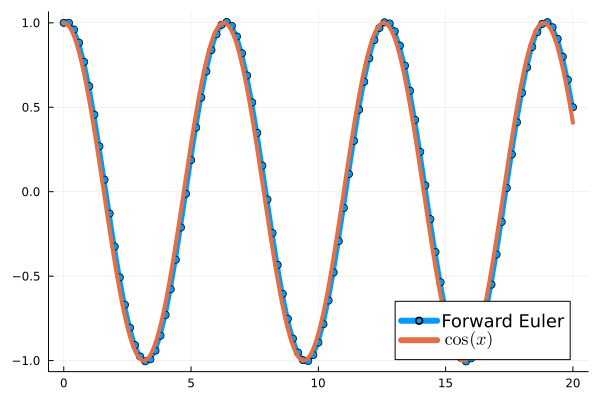

In [6]:
f1(t, y; k=10) = -k * (y .- cos(t))

thist, yhist = ode_euler(f1, [1.], tfinal=20, h=.2)
plot(thist, yhist[1,:], marker=:circle, label = "Forward Euler")
plot!(cos, label = L"\cos(x)")

### Forward Euler on a linear system

If we have a system of ODEs:

$$
\dot{\mathbf{y}} = A \mathbf{y}
$$

For example, a system of two first-order linear ODEs:

\begin{align}
y_1' &= y_2\\
y_2' &= - y_1\\
\end{align}

In matrix form: 


$$ \begin{bmatrix} y_1 \\ y_2 \end{bmatrix}' = \begin{bmatrix} 0 & 1 \\ -1 & 0 \end{bmatrix} \begin{bmatrix} y_1 \\ y_2 \end{bmatrix}$$

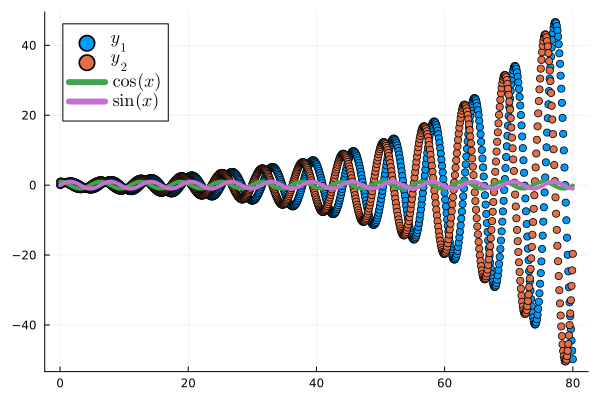

In [7]:
f2(t, y) = [0 1; -1 0] * y

thist, yhist = ode_euler(f2, [0., 1], h=.1, tfinal=80)
scatter(thist, yhist', label = [L"y_1" L"y_2"])
plot!([cos, sin], label = [L"\cos(x)" L"\sin(x)"])

In [5]:
eigvals([0 1; -1 0])

2-element Vector{ComplexF64}:
 0.0 - 1.0im
 0.0 + 1.0im

# Runge-Kutta 4

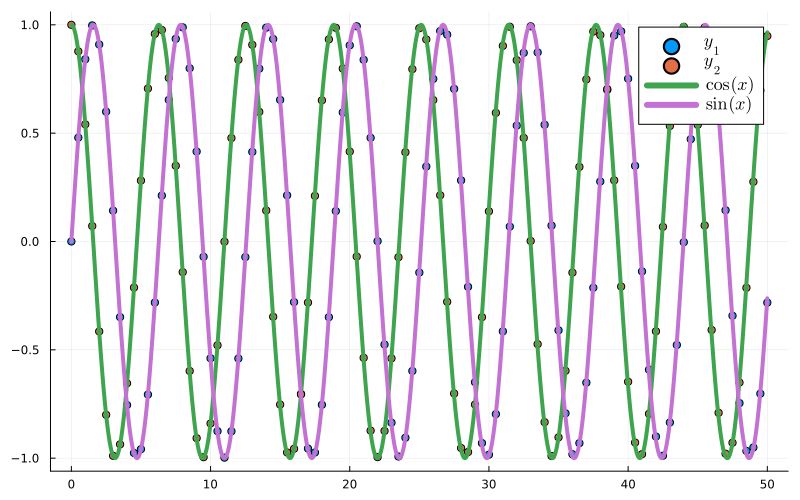

In [9]:
thist, yhist = ode_rk_explicit(f2, [0., 1], h=0.5, tfinal=50)
scatter(thist, yhist', label = [L"y_1" L"y_2"])
plot!([cos, sin], size=(800, 500), label = [L"\cos(x)" L"\sin(x)"])

* Apparently it is possible to integrate this system using large time steps.
* This method evaluates $f(t)$ _four times per step_, so the cost is about equal when the step size $h$ is 4x larger than forward Euler.

But let's run it again with a larger step size
 

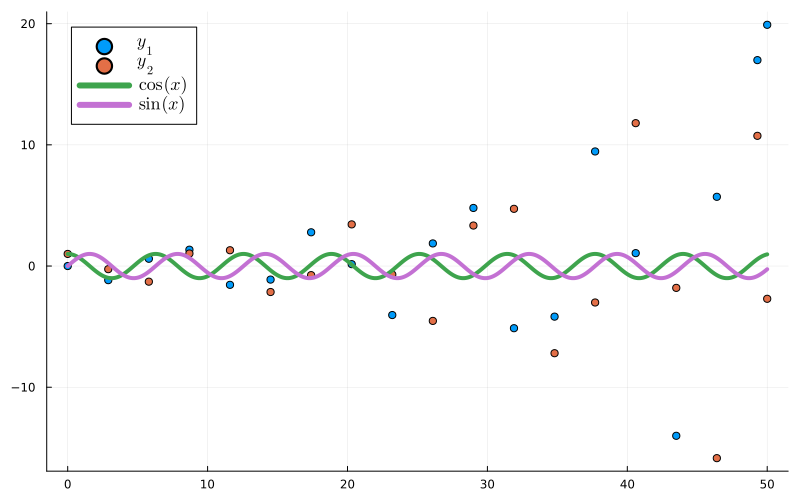

In [11]:
thist, yhist = ode_rk_explicit(f2, [0., 1], h=2.9, tfinal=50)
scatter(thist, yhist', label = [L"y_1" L"y_2"])
plot!([cos, sin], size=(800, 500), label = [L"\cos(x)" L"\sin(x)"])

## Recap on stability

To analyze stability, we use the **Linear Stability Analysis (LSA)**.

### Linear Stability Analysis

Why did Euler diverge (even if slowly) while RK4 solved this problem accurately?

And why do both methods diverge if the step size is too large?

We can understand the convergence of methods by analyzing the test problem

$$ y' = \lambda y $$

for different values of $\lambda$ in the complex plane.

One step of the Euler method with step size $h$ maps

$$ y \to y + h \lambda y = \underbrace{(1 + h \lambda)}_{R(h \lambda)} y .$$

For many ($n \geq 1 $) steps, we have:

$$
y^{n+1} = y^n + h \lambda y^n .
$$

Hence, we obtain the recurrence relation:

$$
y^{n+1} = \underbrace{(1 + h \lambda)}_{R(h \lambda)} y^n,
$$

where $R(h \lambda)$ is called the **recurrence relation** or **growth/amplification factor**.

Our solution will stay bounded, that means the numerical scheme is stable if and only if 

$$

|R(h \lambda)| \leq 1 .
$$

Let's look at examples when this map causes solutions to "blow up" or to be stable.

In [13]:
function plot_stability(Rz, method; xlim=(-3, 2), ylim=(-1.5, 1.5))
    x = xlim[1]:.02:xlim[2]
    y = ylim[1]:.02:ylim[2]
    plot(title="Stability: $method", aspect_ratio=:equal, xlim=xlim, ylim=ylim)
    heatmap!(x, y, (x, y) -> abs(Rz(x + 1im*y)), c=:bwr, clims=(0, 2))
    contour!(x, y, (x, y) -> abs(Rz(x + 1im*y)), color=:black, linewidth=2, levels=[1.])
    plot!(x->0, color=:black, linewidth=1, label=:none)
    plot!([0, 0], [ylim...], color=:black, linewidth=1, label=:none)
end

plot_stability (generic function with 1 method)

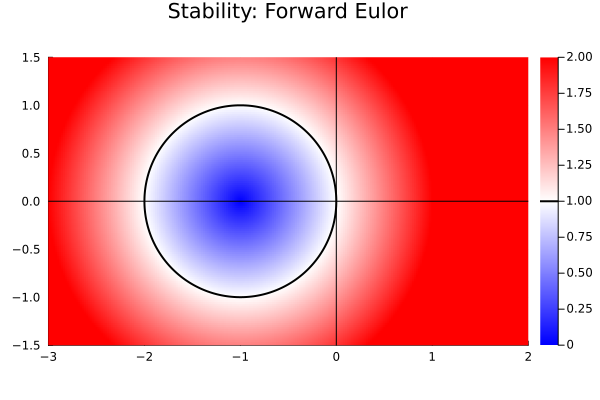

In [8]:
plot_stability(z -> 1 + z, "Forward Eulor")

This is a complex $\lambda h $ (or $\lambda \Delta t$)-plane.

### Stability for RK4

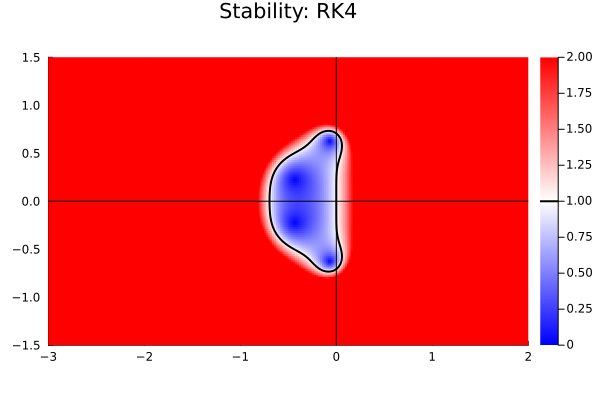

In [9]:
plot_stability(z -> rk_stability(4z, rk4), "RK4")


### Stability for [Heun's method](https://en.wikipedia.org/wiki/Heun%27s_method)

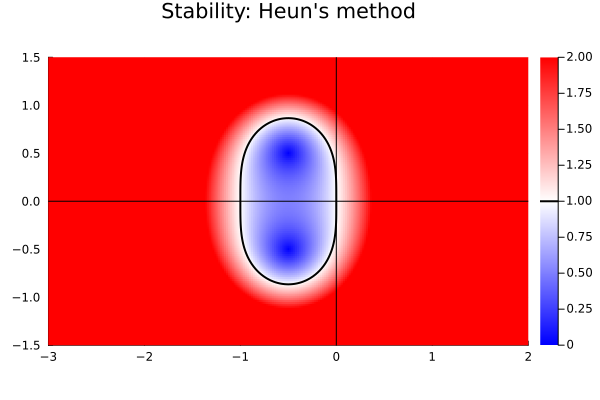

In [10]:
plot_stability(z -> rk_stability(2z, heun), "Heun's method")

## Recap on implicit methods: Backward Euler

Recall that one forward Euler step is

$$ \tilde y(h) = y(0) + h f(0, y(0)) . $$

This can be evaluated **explicitly**; all the terms on the right hand side are known so the approximation $\tilde y(h)$ is computed merely by evaluating the right hand side.

Let's consider an alternative, **backward Euler** (or "implicit Euler"). 

Recall the **forward difference** formula:

$$
\frac{\partial {y^n}^F}{\partial t} \approx \frac{ y^{n+1} - y^{n}}{h} + O(h) \equiv \frac{ y^{n+1} - y^{n}}{\Delta t} + O(\Delta t)
$$

If instead we use the **backward difference** formula:

$$
\frac{\partial {y^{n}}^B}{\partial t} \approx \frac{ y^{n} - y^{n-1}}{h} + O(h) \equiv \frac{ y^{n} - y^{n-1}}{\Delta t} + O(\Delta t)
$$

When $n=1$ we use the **initial condition** given: $y(t=t_0=0)=y(0)=y_0$

$$ y'(t=t_1) \approx \frac{y(h) - y(0)}{h} $$

which yields 

$$ y'(t=t_1) \approx \frac{y(h) - y(0)}{h} = f(t=t_1, y(t=t_1)) $$

which yields to the solution estimate

$$ \tilde y(h) = y(0) + h f(h, \tilde y(h)) . $$

This is a (generally) _nonlinear_ equation for $\tilde y(h)$.

### Stability of backward Euler

For the test equation

$$ 
y' = \lambda y
$$, 

at the first time step, the backward Euler method is

$$ \tilde y(h) = y(0) + h \lambda \tilde y(h), $$

or

$$  \underbrace{\left(1 - h \lambda\right)}_{R(h\lambda)}   \tilde y(h) =  y(0) , $$

hence

$$ \tilde y(h) = \underbrace{\frac{1}{1 - h \lambda}}_{R(h\lambda)} y(0) . $$

For many steps, $(n \geq 1)$, we obtain:

$$
y^{n+1} = y^n + h \lambda y^{n+1} .
$$

Hence, we obtain the recurrence relation:

$$
\underbrace{\left( 1 - h \lambda \right)}_{R(h \lambda)} y^{n+1} = y^n,
$$

$$
 y^{n+1} = \frac{1}{\underbrace{\left( 1 - h \lambda \right)}_{R(h \lambda)}}y^n.
$$

If we apply this repeatedly, we obtain:

$$
 y^{n+1} = \left( \frac{1}{1 - h \lambda } \right)^{n+1} y^0.
$$

We see that to have stability for the **Backward Euler** scheme we need:

$$
\left| \frac{1}{1 - h \lambda } \right| \leq 1 .
$$

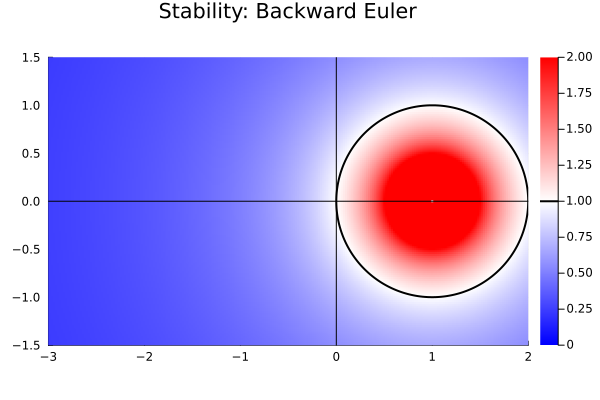

In [11]:
plot_stability(z -> 1/(1-z), "Backward Euler")

We can see that the stability region is for $h \lambda$ anywhere in the left half complex plane, i.e., for any $h>0$ when $Re(\lambda)<0$.

- This means that if the problem of interest is stable $\Rightarrow$ **Backward Euler** is **unconditionally stable**, i.e., stable for any positive step size $h$.

#### Computing with implicit methods

$$ \tilde y(h) = y(0) + h f\big(\tilde y(h) \big) $$

* Linear solve for linear problem
* Nonlinear (often Newton) solve for nonlinear problem
* Need Jacobian or finite differencing

### Recap on stability of midpoint [(Crank-Nicolson)](https://en.wikipedia.org/wiki/Crank%E2%80%93Nicolson_method) scheme

For the test equation 

$$y' = \lambda y, $$

one step of the **Crank-Nicolson** scheme is

$$
\frac{y(h) - y(0)}{h} = \frac{1}{2} \left( f( y(0))  + f(y(h)) \right)
$$,

which leads to the solution estimate

$$
\tilde y(h)  =  y(0) + h  \frac{1}{2} \left( f( y(0))  + f(\tilde y(h)) \right) .
$$

We use the test problem:

$$
y' = \lambda y 
$$, 

and we obtain:

$$
\tilde y(h)  =  y(0) +  \frac{h \lambda}{2} y(0)  + \frac{h \lambda}{2} \tilde y(h) ,
$$

which we can rearrange:

$$
\left(1 - \frac{h \lambda}{2} \right) \tilde y(h)  = \left(1 + \frac{h \lambda}{2} \right) y(0) ,
$$

$$
 \tilde y(h)  = \left(\frac{ 1 + \frac{h \lambda}{2}  }{1 - \frac{h \lambda}{2}}  \right) y(0) .
$$

For many steps, $(n \geq 1)$, we obtain:

$$
y^{n+1} = \underbrace{\left(\frac{ 1 + \frac{h \lambda}{2}  }{1 - \frac{h \lambda}{2}}  \right)}_{R(h\lambda)}  y^n  .
$$


If we apply this repeatedly, we obtain:

$$
 y^{n+1} = \left(\frac{ 1 + \frac{h \lambda}{2}  }{1 - \frac{h \lambda}{2}}  \right)^{n+1} y^0.
$$

We see that to have stability for the **Crank-Nicolson** scheme we need:

$$
\left| \frac{ 1 + \frac{h \lambda}{2}  }{1 - \frac{h \lambda}{2}}   \right| \leq 1 .
$$


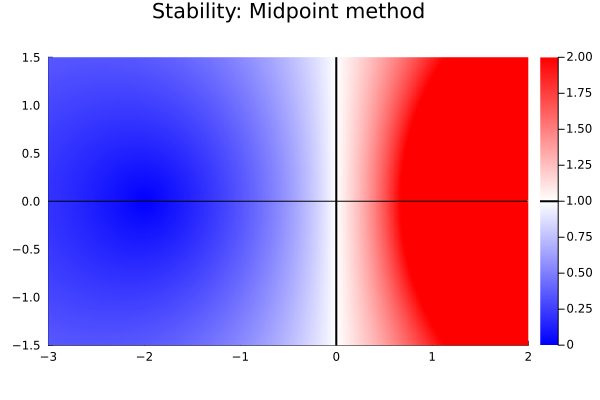

In [12]:
plot_stability(z -> Rz_theta(z, .5), "Midpoint method")

Again, similarly to the case for Backward Euler, we can see here that the stability region is for $h \lambda$ anywhere in the left half complex plane, i.e., for any $h>0$ when $Re(\lambda)<0$.

- This means that if the problem of interest is stable $\Rightarrow$ **Crank-Nicolson** is **unconditionally stable**, i.e., stable for any positive step size $h$.

## 1. The $\theta$ methods


Forward and backward Euler are bookends of the family known as $\theta$ methods, with Crank-Nicolson (or midpoint) exactly in the middle.

We can express a family of methods with the parameter $\theta$. One step of the $\theta$-method looks like this:

$$ \tilde u(h) = u(0) + h f\Big(\theta h, \theta\tilde u(h) + (1-\theta)u(0) \Big) $$

which, for linear problems, is solved as

$$ (I - h \theta A) u(h) = \Big(I + h (1-\theta) A \Big) u(0) . $$

$\theta=0$ is **explicit Euler**, $\theta=1$ is **implicit Euler**, and $\theta=1/2$ is the midpoint/trapezoid or Crank-Nicolson method (equivalent for linear problems).

The stability function (or growth/amplification factor) in this case is:

$$ R(h \lambda) = \frac{1 + (1-\theta)h \lambda}{1 - \theta h \lambda}. $$

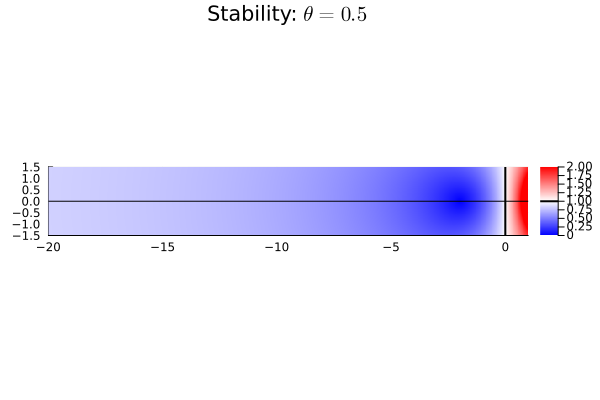

In [14]:
Rz_theta(z, theta) = (1 + (1-theta)*z) / (1 - theta*z)
theta = .5
plot_stability(z -> Rz_theta(z, theta), "\$\\theta=$theta\$",
    xlim=(-20, 1))

### $\theta$ method for the oscillator

In [15]:
function ode_theta_linear(A, u0; forcing=zero, tfinal=1, h=0.1, theta=.5)
    u = copy(u0)
    t = 0.
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        rhs = (I + h*(1-theta)*A) * u .+ h*forcing(t+h*theta)
        u = (I - h*theta*A) \ rhs
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

ode_theta_linear (generic function with 1 method)

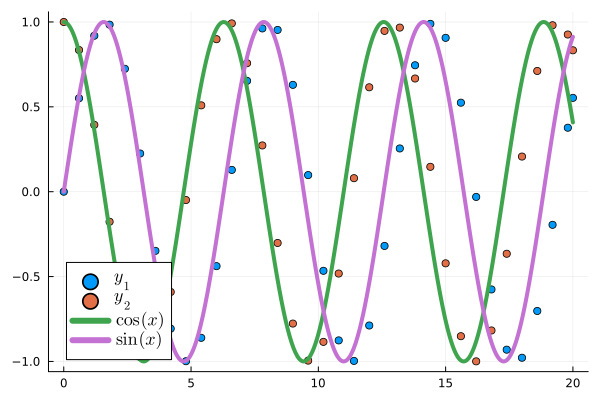

In [19]:
# Test on oscillator
A = [0 1; -1 0]
theta = .5
thist, uhist = ode_theta_linear(A, [0., 1], h=.6, theta=theta, tfinal=20)
scatter(thist, uhist', label = [L"y_1" L"y_2"])
plot!([cos, sin], label = [L"\cos(x)" L"\sin(x)"])

### $\theta$ method for the cosine decay

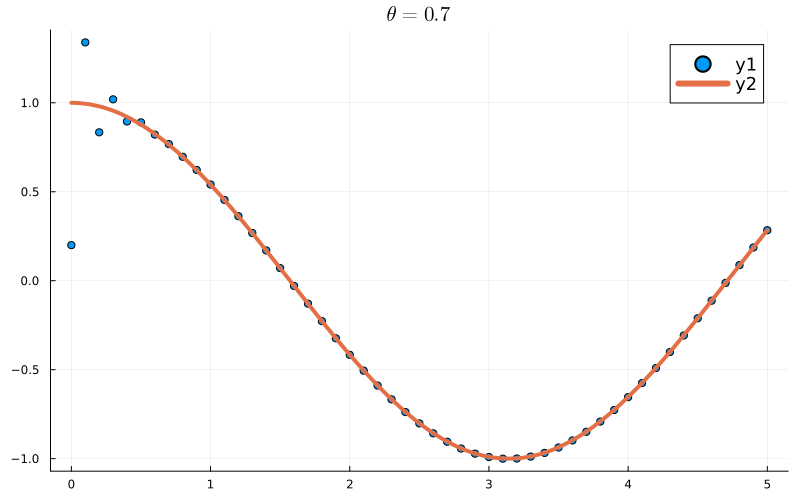

In [20]:
k = 500000
theta = .7
thist, uhist = ode_theta_linear(-k, [.2], forcing=t -> k*cos(t), tfinal=5, h=.1, theta=theta)
scatter(thist, uhist[1,:], title="\$\\theta = $theta\$")
plot!(cos, size=(800, 500))

### Stability classes and the $\theta$ method


## 2. $A$-stability
A method is $A$-stable if the stability region
$$ \{ z : |R(z)| \le 1 \} $$
contains the entire left half plane $$ \Re[z] \le 0 .$$
This means that the method can take arbitrarily large time steps without becoming unstable (diverging) for any problem that is indeed physically stable.

## 3. $L$-stability
A time integrator with stability function $R(z)$ is $L$-stable if
$$ \lim_{z\to\infty} R(z) = 0 .$$
For the $\theta$ method, we have
$$ \lim_{z\to \infty} \frac{1 + (1-\theta)z}{1 - \theta z} = \frac{1-\theta}{\theta} . $$
Evidently only $\theta=1$ is $L$-stable.

### Example: Heat equation as linear ODE

* How do different $\theta \in [0, 1]$ compare in terms of stability?
* Are there artifacts even when the solution is stable?

In [21]:
using SparseArrays

function heat_matrix(n)
    dx = 2 / n
    rows = [1]
    cols = [1]
    vals = [0.]
    wrap(j) = (j + n - 1) % n + 1
    for i in 1:n
        append!(rows, [i, i, i])
        append!(cols, wrap.([i-1, i, i+1]))
        append!(vals, [1, -2, 1] ./ dx^2)
    end
    sparse(rows, cols, vals)
end
heat_matrix(5)

5×5 SparseMatrixCSC{Float64, Int64} with 15 stored entries:
 -12.5     6.25     ⋅       ⋅      6.25
   6.25  -12.5     6.25     ⋅       ⋅ 
    ⋅      6.25  -12.5     6.25     ⋅ 
    ⋅       ⋅      6.25  -12.5     6.25
   6.25     ⋅       ⋅      6.25  -12.5

  0.001373 seconds (846 allocations: 1.483 MiB)


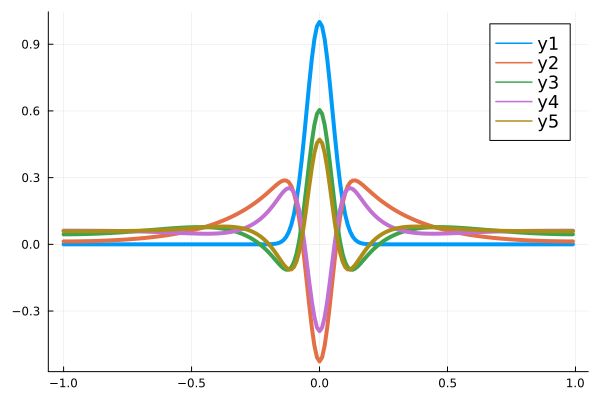

In [111]:
n = 200
A = heat_matrix(n)
x = LinRange(-1, 1, n+1)[1:end-1]
u0 = exp.(-200 * x .^ 2)
@time thist, uhist = ode_theta_linear(A, u0, h=.1, theta=.5, tfinal=1);
nsteps = size(uhist, 2)
plot(x, uhist[:, 1:5])

### Example: Advection as a linear ODE

In [22]:
function advect_matrix(n; upwind=false)
    dx = 2 / n
    rows = [1]
    cols = [1]
    vals = [0.]
    wrap(j) = (j + n - 1) % n + 1
    for i in 1:n
        append!(rows, [i, i])
        if upwind
            append!(cols, wrap.([i-1, i]))
            append!(vals, [1., -1] ./ dx)
        else
            append!(cols, wrap.([i-1, i+1]))
            append!(vals, [1., -1] ./ 2dx)
        end
    end
    sparse(rows, cols, vals)
end
advect_matrix(5)

5×5 SparseMatrixCSC{Float64, Int64} with 11 stored entries:
  0.0   -1.25    ⋅      ⋅     1.25
  1.25    ⋅    -1.25    ⋅      ⋅ 
   ⋅     1.25    ⋅    -1.25    ⋅ 
   ⋅      ⋅     1.25    ⋅    -1.25
 -1.25    ⋅      ⋅     1.25    ⋅ 

  0.075686 seconds (154.41 k allocations: 9.739 MiB, 97.59% compilation time)


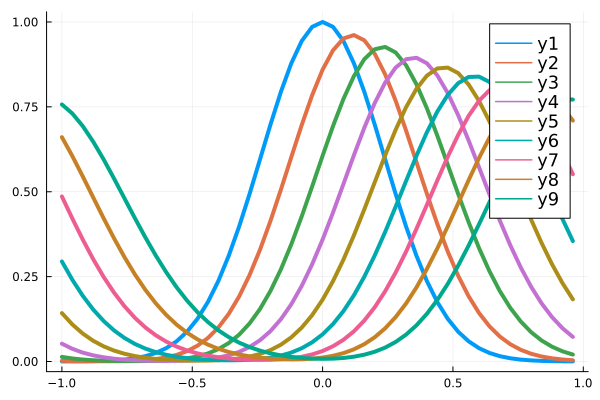

In [20]:
n = 50
A = advect_matrix(n, upwind=false)
x = LinRange(-1, 1, n+1)[1:end-1]
u0 = exp.(-9 * x .^ 2)
@time thist, uhist = ode_theta_linear(A, u0, h=.04, theta=1, tfinal=1.);
nsteps = size(uhist, 2)
plot(x, uhist[:, 1:(nsteps÷8):end])

### Spectrum of operators

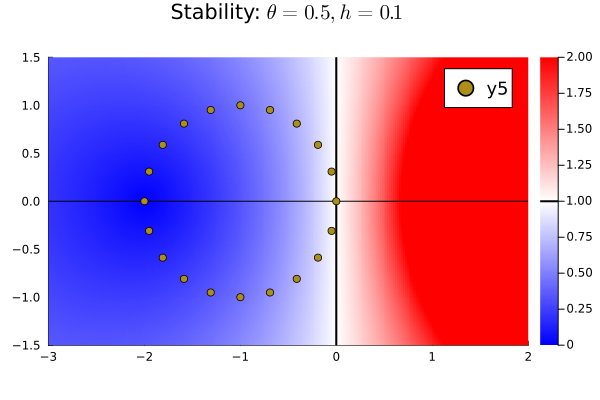

In [23]:
theta=.5
h = .1
plot_stability(z -> Rz_theta(z, theta), "\$\\theta=$theta, h=$h\$")
ev = eigvals(Matrix(h*advect_matrix(20, upwind=true)))
scatter!(real(ev), imag(ev))

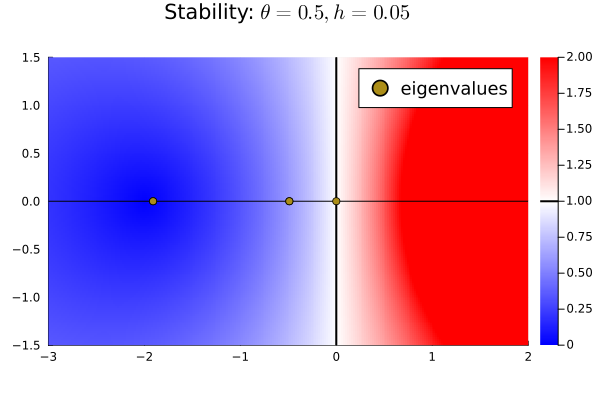

In [24]:
theta=.5
h = .2 / 4
plot_stability(z -> Rz_theta(z, theta), "\$\\theta=$theta, h=$h\$")
ev = eigvals(Matrix(h*heat_matrix(20)))
scatter!(real(ev), imag(ev), label = "eigenvalues")